In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()
import ipywidgets as ipw
from bmcs_shear_zone.api import SteelMaterialModel, ConcreteMaterialModel

In [2]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

# Fracture process segment

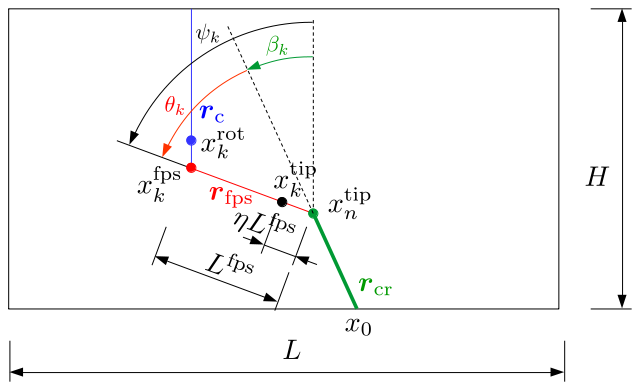

The crack path consists of three segments. The lower segment $x_\mathrm{L}$ represents the localized crack. It can be represented by a continuous curve, i.e. spline or by piecewise linear geometry. The upper segment $x_\mathrm{U}$ represents the uncracked zone. The segments in-between represents the fracture process zone FZP which has a fixed length $L^\mathrm{fps}$ and orientation $\theta$ related to the vertical direction $z$. The coordinates of the segment start $x^{\mathrm{fps}}_{ak}$ is implicitly considered to be in the state of peak tensile stress. The position of the tip of the segment is then given as
\begin{align}
x^{\mathrm{fps}}_{ak} = x^{\mathrm{tip}}_{an} + L^{\mathrm{fps}} 
\left[
\begin{array}{c}
-\sin(\beta) \\ \cos(\beta) 
\end{array}
\right] 
\end{align}

In [3]:
beta = sp.symbols(r'\beta', nonnegative=True)
theta = sp.symbols(r'\theta', nonnegative=True)
psi = sp.symbols(r'\psi', nonnegative=True)
phi = sp.symbols(r'\phi', nonnegative=True)
L_fps = sp.symbols(r'L_\mathrm{fps}', nonnegative=True)
ell = sp.symbols(r'\ell', nonnegative=True)

# Identify the rotation for given crack opening

Kinematics of the section based on the assumption 
that the right side of the shear zone rotates relatively 
to the fixed left side around an unknown position $x^{\mathrm{rot}}_{ak}$. The horizontal position of the center of rotation is assumed identical with the tip of the process zone segment $x^{\mathrm{tip}}_{ak}$, i.e.
\begin{align}
x^{\mathrm{rot}}_{0k} = x^{\mathrm{tip}}_{0k}
\end{align}

The criterion of a crack reaching the strength is defined in strains. This brings about the possibility to circumvent the discussion on the bi-axial stress criterion. This can be seen in analogy to a compression test failure simulated as micro-cracking with cracks oriented in the loading direction.
For this purpose, it is important to include the 

In [4]:
theta, x_rot_1k = sp.symbols(
   r'theta, x^\mathrm{rot}_{1k}', nonegative=True
)
phi, psi = sp.symbols(
   r'phi, psi', nonegative=True
)
x_tip_0n = sp.symbols(r'x^{\mathrm{tip}}_{0n}')
x_tip_1n = sp.symbols(r'x^{\mathrm{tip}}_{1n}')
xi = sp.symbols('xi')
w = sp.Symbol(r'w_\mathrm{cr}', nonnegative=True)

Require that at the crack tip, the crack opening $w$ is equal to critical crack opening 
\begin{align}
w_\mathrm{cr} = \frac{ f_\mathrm{t} } { E_\mathrm{c} } L_{c}
\end{align}
where $L_\mathrm{c}$ represents the characteristic length.

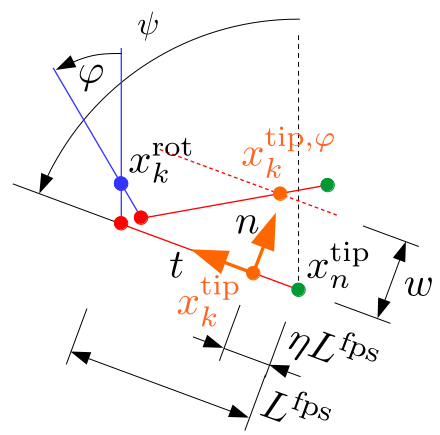

In [5]:
c_beta = sp.Symbol('c_beta')
s_beta = sp.Symbol('s_beta')

Assembling the unit vector components into the vector
\begin{align}
B_c = [ \cos(\beta), \sin(\beta) ]
\end{align}

In [6]:
B = sp.Matrix([c_beta, s_beta])
B_ = sp.Matrix([sp.cos(beta), sp.sin(beta)])

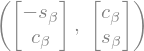

In [7]:
t_vec = sp.Matrix([-s_beta, c_beta])
n_vec = sp.Matrix([c_beta, s_beta])
t_vec, n_vec

In [8]:
x_tip_an = sp.Matrix([x_tip_0n, x_tip_1n])
x_fps_ak = x_tip_an + L_fps * t_vec
x_rot_0k = x_fps_ak[0]
x_rot_0k

 * $t$ is the line vector of the fracture propagation segment
 * $n$ is a vector normal to the fracture propagation segment

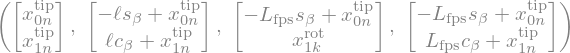

In [9]:
x_tip_ak = x_tip_an + ell * t_vec
x_rot_ak = sp.Matrix([x_rot_0k, x_rot_1k])
x_tip_an, x_tip_ak, x_rot_ak, x_fps_ak

The final position must be on a line parallel to $t$ in 
the distance $w$
\begin{align}
x^{\mathrm{tip},\varphi}_{ak} = x^{\mathrm{tip}}_{ak} + w \, n_{ak} + \xi \, t_{ak}
\end{align}

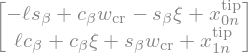

In [10]:
x_theta_xi_ak = x_tip_ak + w * n_vec + xi * t_vec
x_theta_xi_ak

Vector connecting rotation center with the curent crack tip point on the fixed plate $k$ 
\begin{align}
p_{a} = x^{\mathrm{tip}}_{ak} - x^{\mathrm{rot}}_{ak}
\end{align}

Vector connecting the rotation center with the current crak tip point on the rotated plate
\begin{align}
q_{a}(\xi)
= x^{\mathrm{tip},\varphi}_{ak}(\xi) - x^{\mathrm{rot}}_{ak}
\end{align}

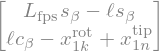

In [11]:
p_a = (x_tip_ak - x_rot_ak)
p_a

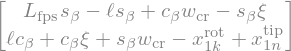

In [12]:
q_xi_a = (x_theta_xi_ak - x_rot_ak)
q_xi_a

The lengths of vectors $p_a$ and $q_a$ must be equal
\begin{align}
 \| p \| 
&=
 \| q^\xi \|
 \; \implies
 \sqrt{p_{a}  p_{a}} = 
 \sqrt{q_{a}^\xi  q_a^\xi} \; \implies
 p_a p_a = q_a^\xi q_a^\xi
\end{align}

In [13]:
pp = p_a.T * p_a
qq_xi = q_xi_a.T * q_xi_a

The equal distance can be used to resolve the unknown slip parameter $\xi$  

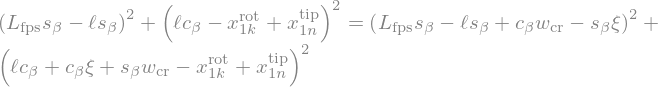

In [14]:
Eq_xi_ = sp.Eq(pp[0], qq_xi[0])
Eq_xi_

In [15]:
xi_solved = sp.solve(Eq_xi_, xi)[0]
xi_solved_c = xi_solved.subs(c_beta**2 + s_beta**2,1)

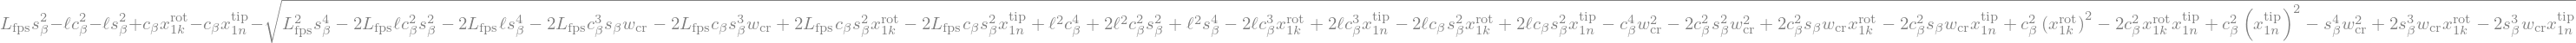

In [16]:
sp.simplify(xi_solved_c)

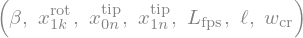

In [17]:
py_vars = ('beta', 'x_rot_1k', 'x_tip_0n', 'x_tip_1n', 'L_fps', 'ell', 'w')
get_params = lambda py_vars, **kw: tuple(kw[name] for name in py_vars)
sp_vars = tuple(globals()[py_var] for py_var in py_vars)
sp_vars

In [18]:
get_params(py_vars, beta=0, x_rot_1k=1, x_tip_0n=0, x_tip_1n=0, L_fps=0.1, ell=0.1, w=0.1)

In [19]:
get_B = sp.lambdify(sp_vars, B_)
get_xi_B = sp.lambdify(sp_vars + (c_beta, s_beta), xi_solved)
def get_xi(*params):
    B_ = get_B(*params)
    xi_ = get_xi_B(*(params + tuple(B_)))
    return xi_[0]

In [20]:
params = 0, 1, 0, 0, 0.1, 0.1, 0.1
param_dict = dict(
    beta=0, x_rot_1k=1, x_tip_0n=0, x_tip_1n=0, L_fps=0.1, ell=0.1, w=0.1
)
get_xi(*params), get_xi(*get_params(py_vars,**param_dict))

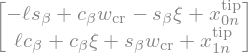

In [21]:
x_theta_xi_ak

In [22]:
get_x_theta_B_ak = sp.lambdify(sp_vars + (c_beta, s_beta, xi), x_theta_xi_ak)
def get_x_theta_ak(*params):
    xi = get_xi_B(*params)
    return get_x_theta_B_ak(*(params + (xi,)))
get_x_tip_an = sp.lambdify(sp_vars + (c_beta, s_beta), x_tip_an)
get_x_tip_ak = sp.lambdify(sp_vars + (c_beta, s_beta), x_tip_ak)
get_x_rot_ak = sp.lambdify(sp_vars + (c_beta, s_beta), x_rot_ak)
get_x_fps_ak = sp.lambdify(sp_vars + (c_beta, s_beta), x_fps_ak)
get_p_a = sp.lambdify(sp_vars + (c_beta, s_beta), p_a)
get_q_xi_a = sp.lambdify(sp_vars + (c_beta, s_beta, xi), q_xi_a)
def get_q_a(*params):
    xi = get_xi_cs(*params)
    return get_q_xi_a(*(params + (xi,)))

In [23]:
get_x_fps_ak(*(params + (0,1)))

array([[-0.1],
       [ 0. ]])

# Derivatives of the side rotation vectors $p, q$

To derive an efficient Newton-Raphson algorithm, let us directly prepare the derivatives of $\xi$ with respect to the angle primary unknowns - crack inclination $\theta$ and to the vertical position of the center of rotation $x^\mathrm{rot}_{1k}$ assembled in a vector
\begin{align}
\zeta_I = [ \beta, x_{1k}^\mathrm{rot} ]
\end{align}
As the solution of $(\xi, x^\mathrm{rot}_{1k})$ has been obtained in terms of $\cos(\beta)$ and $\sin(\beta)$ the derivatives
\begin{align}
\frac{\partial \xi}{\partial \zeta_I} &= \xi_{,I} =
\left[\frac{\partial \xi}{\partial \beta}, \frac{\partial \xi}{\partial x^\mathrm{rot}_{1k}}\right]
\end{align}
where
\begin{align}
\frac{\partial \xi}{\partial \beta} &=
\frac{\partial \xi}{\partial \cos(\beta)} 
\frac{\partial \cos(\theta)}{\partial \beta} +
\frac{\partial \xi}{\partial \sin(\beta)} 
\frac{\partial \sin(\theta)}{\partial \beta} \\
&= \frac{\partial \xi}{\partial B_c} \frac{\partial B_c}{\partial \beta}
\end{align}

In [24]:
dxi_dB = xi_solved_c.diff(B)
dB_dbeta = B_.diff(beta)
dB_dbeta_ = dB_dbeta.subs(
    {sp.cos(beta):c_beta, sp.sin(beta): s_beta})
dxi_beta = (dxi_dB.T * dB_dbeta)[0,0]
dxi_x_rot_1k = xi_solved_c.diff(x_rot_1k)
get_dxi_beta = sp.lambdify(sp_vars + (c_beta, s_beta), dxi_beta)
get_dxi_x_rot_1k = sp.lambdify(sp_vars + (c_beta, s_beta), dxi_x_rot_1k)

Derivatives of the left side vector $p_{,I}$ with respect to $\beta$
\begin{align}
p_{a,\beta} = p_{a,B_c} B_{c,\beta}
\end{align}
and with respect to $x^\mathrm{rot}_{1k}$
\begin{align}
p_{a,x_{1k}^\mathrm{rot}} = 
\left[
\begin{array}{c}0 \\ -1 \end{array}
\right]
\end{align}

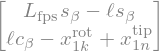

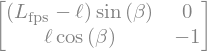

In [25]:
display(p_a)
dp_a_beta = sp.Matrix([p_a.T.diff(c) for c in B]).T * B_
dp_a_x_rot_1k = p_a.diff(x_rot_1k)
dp_aI_ = sp.Matrix([dp_a_beta.T, dp_a_x_rot_1k.T]).T
display(dp_aI_)

In [26]:
get_dp_a_beta = sp.lambdify(sp_vars + (c_beta, s_beta), dp_a_beta)
get_dp_a_x_rot_1k = sp.lambdify(sp_vars + (c_beta, s_beta), dp_a_x_rot_1k)
def get_p_a_dI(*params):
    p_a = get_p_a(*params)
    dp_a_beta = get_dp_a_beta(*params)
    dp_a_x_rot_1k = get_dp_a_x_rot_1k(*params)
    return p_a[:,0], np.c_[dp_a_beta, dp_a_x_rot_1k] 
get_p_a_dI(*(params + (0,1)))

(array([ 0., -1.]),
 array([[ 0. ,  0. ],
        [ 0.1, -1. ]]))

Derivatives of the right plate vector $q_{,I}$ with respect to $\theta$
\begin{align}
q_{a,beta} = q_{a,B_c} B_{c,beta} + q_{a,\xi} \xi_{,\beta}
\end{align}
and with respect to $x^\mathrm{rot}_{1k}$
\begin{align}
q_{a,x_{1k}^\mathrm{rot}} = 
\left[\begin{array}{c}0 \\ -1\end{array}\right] +
q_{a,\xi} \xi_{,x^\mathrm{rot}_{1k}}
\end{align}

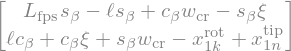

In [27]:
display(q_xi_a)
dq_a_beta_dir = sp.Matrix([q_xi_a.T.diff(c) for c in B]).T * dB_dbeta_
dq_a_xi = q_xi_a.diff(xi)
dq_a_x_rot_1k_dir = q_xi_a.diff(x_rot_1k)
dq_aI_dir_ = sp.Matrix([dq_a_beta_dir.T, dq_a_x_rot_1k_dir.T]).T

In [28]:
get_dq_a_beta_dir = sp.lambdify(sp_vars + (c_beta, s_beta, xi), dq_a_beta_dir)
get_dq_a_x_rot_1k_dir = sp.lambdify(sp_vars + (c_beta, s_beta, xi), dq_a_x_rot_1k_dir)
get_dq_a_xi = sp.lambdify(sp_vars + (c_beta, s_beta), dq_a_xi)
def get_q_a_dI(*params):
    xi = get_xi_B(*params)
    q_a = get_q_xi_a(*(params + (xi,)))
    dq_a_beta_dir = get_dq_a_beta_dir(*(params + (xi,)))
    dq_a_xi = get_dq_a_xi(*params)
    dxi_beta = get_dxi_beta(*params)
    dq_a_beta = dq_a_beta_dir + dq_a_xi * dxi_beta
    dq_a_x_rot_1k_dir = get_dq_a_x_rot_1k_dir(*(params + (xi,)))
    dxi_x_rot_1k = get_dxi_x_rot_1k(*params)
    dq_a_x_rot_1k = dq_a_x_rot_1k_dir + dq_a_xi * dxi_x_rot_1k
    return q_a[:,0], np.c_[dq_a_beta, dq_a_x_rot_1k] 
get_q_a_dI(*(params + (0,1)))

(array([ 0.43588989, -0.9       ]),
 array([[ 0.54236405,  0.22941573],
        [ 0.33588989, -1.        ]]))

# Rotation angle and rotation matrix 

To abbreviate notation, let us denote vector connecting the center of rotation 
$x^\mathrm{rot}_{ak}$ and $x^\mathrm{tip}_{ak}$ as $p_{a}$ and the 
rotated
vector $x^\mathrm{rot}_{ak}, v_{ak}^\mathrm{\varphi}$ as $q_{ak}$. 

the $\cos$ and $\sin$ 
needed for the rotation matrix is then expressed as
\begin{align}
\| p \| &= \sqrt{p_{a} p_{a}} = \left( p_{a} p_{a} \right)^{\frac{1}{2}}
\end{align}
\begin{align}
\| q \| &= \sqrt{q_{a} q_{a}} = \left( q_{a} q_{a} \right)^{\frac{1}{2}}
\end{align}

\begin{align}
\cos(\theta) &=
\frac
{p_{a} q_{a}}
{\| p \| \| q \| }
\end{align}

In [29]:
zeta = sp.Symbol('\zeta')

Assuming that the vectors $p_a$ and $q_a$ both depend on a vector $\zeta_I$, 
let us denote the derivatives of both vectors with respect to these variables as
\begin{align}
\frac{\partial p_a}{\partial \zeta_I} &= p_{a,I}  \\
\frac{\partial q_a}{\partial \zeta_I} &= q_{a,I}  \\
\end{align}

Derivative of their scalar product

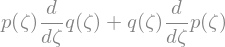

In [30]:
p_zeta = sp.Function('p')(zeta)
q_zeta = sp.Function('q')(zeta)
(p_zeta * q_zeta).diff(zeta)

\begin{align}
(pq)_{,I} = p_{a,I} q_a + p_a q_{a,I}
\end{align}

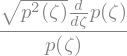

In [31]:
(sp.sqrt(p_zeta*p_zeta)).diff(zeta)

Derivative of the vector norms
\begin{align}
\| p \|_{,I} &= \left[ \left( p_a p_a \right)^{\frac{1}{2}} \right]_{,I}
\\
&= \frac{1}{2}\left( p_a p_a \right)^{-\frac{1}{2}}   2 p_{a,I} p_a \\
&= \frac{p_a}{\|p\|} p_{a,I} \\
\| q \|_{,I} &= \frac{q_a}{\|q\|} q_{a,I}
\end{align}

Derivative of the norm product
\begin{align}
(\| p \| \| q \|)_{,I} &= \| p \|_{,I} \| q \| + \| p \| \| q \|_{,I}
\end{align}

Derivative of division of two functions of $\zeta_I$

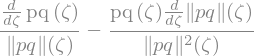

In [32]:
pq_zeta = sp.Function(r'pq')(zeta)
norm_pq_zeta = sp.Function(r'\|pq\|')(zeta)
(pq_zeta/norm_pq_zeta).diff(zeta)

Thus, the derivative of the cosine can be obtained as
\begin{align}
\cos_{,I}\theta &=  \frac{1}{\| p \| \| q \| }
\left[
(pq)_{,I} -
\frac{pq }
{\| p \| \| q \|}
(\| p \| \| q \|)_{,I}
\right] \\
&=  \frac{1}{\| p \| \| q \| }
\left[
(pq)_{,I} -
\cos(\theta) \, (\| p \| \| q \|)_{,I}
\right] 
\end{align}

Since
\begin{align}
\sin \theta = \sqrt{ 1 - \cos^2{\theta}}
\end{align}
we can obtain
\begin{align}
\sin_{,I}\theta &= 
\frac{1}{2\sqrt{ 1 - \cos^2\theta }}
\cdot (-2) \cos \theta \cdot \cos_{,I}\theta \\
&= - \frac{\cos \theta}{\sin{\theta}}
 \cdot \cos_{,I}\theta \\
\end{align}

In [33]:
def get_cos_theta_dI(p_a, q_a, dp_aI, dq_aI):
    pq = np.einsum('a,a',p_a,q_a)
    norm_p = np.sqrt(np.einsum('a,a',p_a,p_a))
    norm_q = np.sqrt(np.einsum('a,a',q_a,q_a))
    norm_pq = norm_p * norm_q
    d_pq_I = (
        np.einsum('a,aI->I',p_a,dq_aI) + np.einsum('aI,a->I', dp_aI, q_a)
    )
    d_norm_p_I = np.einsum('a,aI->I',p_a,dp_aI) / norm_p
    d_norm_q_I = np.einsum('a,aI->I',q_a,dq_aI) / norm_q
    d_norm_pq_I = d_norm_p_I * norm_q + norm_p * d_norm_q_I
    cos_theta = pq / norm_pq
    d_cos_theta_I = (d_pq_I - cos_theta * d_norm_pq_I ) / norm_pq
    sin_theta = np.sqrt( 1 - cos_theta**2 )
    d_sin_theta_I = -cos_theta / sin_theta * d_cos_theta_I
    return cos_theta, sin_theta, d_cos_theta_I, d_sin_theta_I

In [34]:
def get_cos_theta_dI2(*params):
    c_beta, s_beta = get_B(*params )
    params_B = params + (c_beta[0], s_beta[0])
    p_a, dp_aI = get_p_a_dI(*params_B)
    q_a, dq_aI = get_q_a_dI(*params_B)
    return get_cos_theta_dI(p_a, q_a, dp_aI, dq_aI)

In [35]:
params = 0, 1, 0, 0, 0.1, 0.1, 0.1
get_cos_theta_dI2(*params)

(0.9938079899999065,
 0.11111111111111135,
 array([0.00069229, 0.01380289]),
 array([-0.00619201, -0.12345679]))

The primary kinematic variables are introduced as the vertical displacement on the left hand side $v$ and the rotation of the left section $\varphi$.

In [36]:
c_theta, s_theta = sp.symbols(r'\cos(\theta), \sin(\theta)')
c_theta = sp.Function(r'cos')(theta)
s_theta = sp.Function(r'sin')(theta)

# Rotation matrix

The rotation matrix is then defined as
\begin{align}
T_{ab}
&=
\left[
\begin{array}{cc}
\cos{\theta} & - \sin{\theta} \\
\sin{\theta} & \cos{\theta}
\end{array}
\right]
\end{align}

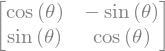

In [37]:
T = sp.Matrix(
        [[c_theta, -s_theta],
         [s_theta, c_theta]], dtype=np.float_)
T

\begin{align}
T_{ab,I} = 
T_{ab,\cos(\theta)} \cos_{,I}(\theta) + 
T_{ab,\sin(\theta)} \sin_{,I}(\theta)
\end{align}

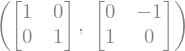

In [38]:
dT_dcs_theta = T.diff(c_theta), T.diff(s_theta)
dT_dcs_theta

In [39]:
get_T = sp.lambdify((c_theta, s_theta), T, 'numpy')
get_dT_dcs = sp.lambdify((c_theta, s_theta), dT_dcs_theta, 'numpy')

In [40]:
def get_T_ab_dT_dI_abI(*params):
    cos_theta, sin_theta, d_cos_theta_I, d_sin_theta_I = get_cos_theta_dI2(
        *params
    )
    cs_c = np.array([cos_theta, sin_theta], dtype=np.float_)
    dcs_cI = np.array([d_cos_theta_I, d_sin_theta_I], dtype=np.float_)
    T_ab = get_T(cos_theta, sin_theta)
    dT_dcs_cab = np.array(get_dT_dcs(cos_theta, sin_theta))
    dT_dI_abI = np.einsum('cab,cI->abI',dT_dcs_cab, dcs_cI)
    return T_ab, dT_dI_abI
T_ab, dT_dI_abI = get_T_ab_dT_dI_abI(*params)

# Rotation operator

Let $x^0_{Lb}$ represent the nodes on the line of the ligament running through the cross section with $L$ segments. This line is fixed on the left-hand side. The only deformation assumed to happen within the studied shear zone is the rotation around the center of rotation $x^\mathrm{rot}_a$. 
The rotated position of a point $x^1_{Lb}$ on the ligmanet $L$ is obtained 
\begin{align}
x^1_{Lb} = T_{ab} (x^0_{La} - x^{\mathrm{rot}}_a ) + x^{\mathrm{rot}}_a
\end{align}
and the derivatives
\begin{align}
x^1_{Lb,I} = 
T_{ab,I} (x^0_{La} - x^{\mathrm{rot}}_a ) +
T_{ab} (x^0_{La,I} - x^{\mathrm{rot}}_{a,I} )
+ 
x^{\mathrm{rot}}_{a,I}
\end{align}

In [41]:
x_rot_0, x_rot_1 = sp.symbols(r'x^{\mathrm{rot}}_0, x^{\mathrm{rot}}_1')
x_rot = sp.Matrix([[x_rot_0], [x_rot_1]])
x_L_0, x_L_1 = sp.symbols(r'x^{\mathrm{L}}_0, x^{\mathrm{L}}_1')
x_L = sp.Matrix([[x_L_0], [x_L_1]])

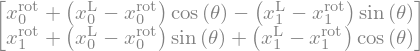

In [42]:
x1_a = sp.simplify(T * (x_L - x_rot) + x_rot)
x1_a

In [43]:
def get_x1_La(T_ab, x0_La, x_rot_a):
    x_rot_La = x_rot_a[np.newaxis,...]
    return np.einsum('ab,Lb->La', T_ab, x0_La - x_rot_La) + x_rot_La

In [44]:
_x0_La = np.array([[1,0]])
_x_rot_a = np.array([0,1])
params = 0, 1, 1, 0, 0.1, 0.1, 0.1
py_vars, params

(('beta', 'x_rot_1k', 'x_tip_0n', 'x_tip_1n', 'L_fps', 'ell', 'w'),
 (0, 1, 1, 0, 0.1, 0.1, 0.1))

In [45]:
_T_ab, _ = get_T_ab_dT_dI_abI(*params)
_T_ab, get_x1_La(T_ab, _x0_La, _x_rot_a)

(array([[ 0.99380799, -0.11111111],
        [ 0.11111111,  0.99380799]]),
 array([[1.1049191 , 0.11730312]]))

In [46]:
_x0_La - _x_rot_a[np.newaxis,...]

array([[ 1, -1]])

In [47]:
np.einsum('ab,b->a', _T_ab, [1,-1])

array([ 1.1049191 , -0.88269688])

**TODO:** Define the chained derivatives for the rotated coordinate
\begin{align}
x^{1}_{a,\beta \zeta} = x^{1}_{,\zeta} + x^{1}_{a, c} c_{,\beta \zeta}
\end{align}

In [48]:
import traits.api as tr
from bmcs_utils.api import InteractiveModel, IPWInteract, mpl_align_xaxis

class SZCrackTipRotation(InteractiveModel):
    
    name = 'Crack tip'
    
    # Define the free parameters as traits with default, min and max values
    beta = tr.Float(0.8, param=True, latex=r'\beta', minmax=(0,np.pi/2))
    x_rot_1k = tr.Float(100, latex=r'x^\mathrm{rot}_{1k}', param=True, minmax=(0,200))
    x_tip_0n = tr.Float(200,  latex=r'x^\mathrm{tip}_{0n}',  param=True, minmax=(0,500))
    x_tip_1n = tr.Float(50, latex=r'x^\mathrm{tip}_{1n}', param=True, minmax=(0,200))
    L_fps = tr.Float(20, latex=r'L_\mathrm{fps}', param=True, minmax=(0,100))
    ell = tr.Float(5, latex=r'\ell', param=True, minmax=(0, 10))
    w = tr.Float(0.3, latex=r'w', param=True, minmax=(0, 20))

    param_names = ['beta','x_rot_1k','x_tip_0n','x_tip_1n','L_fps','ell','w']

    all_points = tr.Property(depends_on='+param')
    @tr.cached_property
    def _get_all_points(self):
        params = self.get_params()
        c_theta, s_theta = get_B(*params)
        params = params + (c_theta[0], s_theta[0])
        x_rot_ak = get_x_rot_ak(*params)
        x_tip_an = get_x_tip_an(*params)
        x_tip_ak = get_x_tip_ak(*params)
        x_theta_ak = get_x_theta_ak(*params)
        x_fps_ak = get_x_fps_ak(*params)
        return x_rot_ak, x_tip_an, x_tip_ak, x_theta_ak, x_fps_ak

    x_rot_ak = tr.Property
    def _get_x_rot_ak(self):
        x_rot_ak, x_tip_an, x_tip_ak, x_theta_ak, x_fps_ak = self.all_points
        return x_rot_ak
    x_tip_an = tr.Property
    def _get_x_tip_an(self):
        x_rot_ak, x_tip_an, x_tip_ak, x_theta_ak, x_fps_ak = self.all_points
        return x_tip_an
    x_tip_ak = tr.Property
    def _get_x_tip_ak(self):
        x_rot_ak, x_tip_an, x_tip_ak, x_theta_ak, x_fps_ak = self.all_points
        return x_tip_ak
    x_theta_ak = tr.Property
    def _get_x_theta_ak(self):
        x_rot_ak, x_tip_an, x_tip_ak, x_theta_ak, x_fps_ak = self.all_points
        return x_theta_ak
    x_fps_ak = tr.Property
    def _get_x_fps_ak(self):
        x_rot_ak, x_tip_an, x_tip_ak, x_theta_ak, x_fps_ak = self.all_points
        return x_fps_ak
    
    def get_T_ab_dT_dI_abI(self):
        params = self.get_params()
        T_ab, dT_dI_abI = get_T_ab_dT_dI_abI(*params)
        return T_ab, dT_dI_abI
        
    def plot_crack_tip_rotation(self, ax):
        ax.plot(*self.x_rot_ak, marker='o', color='blue')
        ax.plot(*self.x_tip_an, marker='o', color='green')
        ax.plot(*self.x_tip_ak, marker='o', color='orange')
        ax.plot(*self.x_theta_ak, marker='o', color='orange')
        ax.plot(*self.x_fps_ak, marker='o', color='red')
        ax.plot(*np.c_[self.x_tip_an, self.x_fps_ak], color='red')
        ax.plot(*np.c_[self.x_fps_ak, self.x_rot_ak], color='blue')

    def update_plot(self, ax):
        ax.clear()
        ax.axis('equal')
        self.plot_crack_tip_rotation(ax)

In [49]:
sz_mechanism_ict = IPWInteract(SZCrackTipRotation(), figsize=(7,3))
sz_mechanism_ict.fig.tight_layout=True
sz_mechanism_ict.interact()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Beam design
Define the initial configuration of the reinforced beam including the geometry and reinforcement layout with associated crack bridge laws.

## Beam geometry
The geometry of the shear zone is defined as length $L$, height $H$ and width $B$. They are defined numerically for the running example as

In [50]:
L_, H_, B_ =  100, 60, 20

The corner coordinates are stored in an array $x_{aC}$ where $a \in (0,1)$ is the dimension index and $C \in (0,1,2,3)$ is the global corner index 

In [51]:
x_aC = np.array([[0, L_, L_, 0], 
                 [0, 0, H_, H_]], dtype=np.float_)
x_Ca = x_aC.T

The lines delimiting the shear zone are defined by an index map $C_{Li}$ with $L \in (0,1,2,3)$ denoting the line and $i \in (0,1)$ the local node index defining a line.

In [52]:
C_iL = np.array([[0,1,2,3],
                 [1,2,3,0]], dtype=np.int_)

**Example:** With this zone definition, the lines can be ordered to an array $x_{iLa}$ using the index operator as follows.

In [53]:
x_iLa = x_Ca[C_iL,:]
np.einsum('iLa->aiL', x_iLa)

array([[[  0., 100., 100.,   0.],
        [100., 100.,   0.,   0.]],

       [[  0.,   0.,  60.,  60.],
        [  0.,  60.,  60.,   0.]]])

## Reinforcement layout

In [54]:
import traits.api as tr
from bmcs_utils.api import InteractiveModel, IPWInteract

class RCBeamDesign(InteractiveModel):
    
    name = 'Beam design'
    
    cmm = tr.Instance(ConcreteMaterialModel,())
    smm = tr.Instance(SteelMaterialModel,())
    
    # Only for visualization to delimit the plotted area
    H = tr.Float(200, param=True, minmax=(1,400), latex=r'H')
    L = tr.Float(800, param=True, minmax=(1,1000), latex=r'L')
    B = tr.Float(100, param=True, minmax=(1,200), latex=r'B')

    param_names = ['H','B','L']

    C_Li = tr.Array(value=[[0,1,2,3],[1,2,3,0]], dtype=np.int_)

    x_Ca = tr.Property(depends_on='+param')
    '''Array of corner nodes [C-node, a-dimension]'''
    @tr.cached_property
    def _get_x_Ca(self):
        x_aC = np.array([[0, self.L, self.L, 0], 
                         [0, 0, self.H, self.H]], dtype=np.float_)
        return x_aC.T

    x_aiM = tr.Property(depends_on='+param')
    '''Array of boundary lines [a-dimension,i-line node,M-line]'''
    @tr.cached_property
    def _get_x_aiM(self):
        x_iCa = self.x_Ca[self.C_Li]
        return np.einsum('iMa->aiM', x_iCa)
    
    def plot_sz_geo(self, ax):
        ax.set_xlim(0,self.L)
        ax.set_ylim(0,self.H)
        ax.plot(*self.x_aiM, color='black')

    def plot_sz_cross_section(self, ax):
        ax.plot([0,self.B,self.B,0,0],
                [0,0,self.H,self.H,0], color='black')
        ax.set_xlim(0,self.B)
        ax.set_ylim(0,self.H)

    def update_plot(self, ax1):
        ax1.axis('equal');
        self.plot_sz_geo(ax1)
#         ax2.axis('equal');
#         self.plot_sz_cross_section(ax2)

In [55]:
rc_bd = RCBeamDesign(H=400)
ipw_plate = IPWInteract([rc_bd, rc_bd.cmm], figsize=(8,3))
ipw_plate.interact()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Crack path

The displacement at the ligament
\begin{align}
u_{Lb} &= x^1_{Lb} - x^0_{Lb}
\end{align}

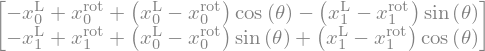

In [56]:
u_L = x1_a - x_L
u_L

Both coordinates of the center of rotation $X^\mathrm{rot}_a$ are unknown. Let us assume for a while that the horizontal coordinate is fixed. Then we can find the vertical coordinate by applying a kinematic constraint requiring that the horizontal displacement at the center of rotation $u_{L0}$ must be zero, i.e.

\begin{align}
u_0( x^\mathrm{rot}_1 ) = 0
\end{align}

In [57]:
u_L0 = u_L[0].subs(x_L_0, x_rot_0)
u_L0

## Crack path

Let us now consider a rotated configuration of the right plate around $x_{ak}^{\mathrm{rot}}$ by the angle $\theta$ inducing the critical crack opening $w_\mathrm{cr}$ at the point $x^{\mathrm{tip}}_{ak}$

By transforming the $u_{Lb}$ to in-line and out-of-line components
\begin{align}
 w_{Lr} = T_{Lar} u_{La}
\end{align}

By applying the constitutive relation
\begin{align}
s_{Ls} = \mathcal{S}_{Ls}(w_{Lr})
\end{align}

Transformation to the global coordinate system
\begin{align}
\sigma_{La} = T_{Las} s_{Ls}
\end{align}

Normal force is obtained by evaluating the integral
\begin{align}
N = \int_{0}^{H} \sigma_{0}(x_1) \; \mathrm{d}x
\end{align}

The vertical position of the center of rotation is obtained by requiring the equality of compressive and tensile force within the cross section
\begin{align}
N(X_1) = 0
\end{align}

At the same tome the shear force gets calculated as 
\begin{align}
Q = 
\int_{\Gamma} \sigma_1(x_1) \; \mathrm{d}x
\end{align}

and the moment around the position $x = 0$ and $y = \hat{X}_1$
\begin{align}
M(x = 0, y = \hat{X}_1) = 
\int \sigma_1 x_0 \; \mathrm{d}x
\end{align}

Global equations are defined as
\begin{align}
 M(\theta, x_{ak}^\mathrm{rot}) - Q(\theta, x_{ak}^\mathrm{rot}) L &= 0 \\
 N(\theta, x_{ak}^\mathrm{rot}) &= 0
\end{align}

## Level set crack path representation

Consider a crack path defined by a level set function
\begin{align}
\gamma( x_a ) = 0
\end{align}
This function consists of three branches. The existing crack $\gamma_0( x_a ) = 0$ which ends at a point $x_a^{\mathrm{tip}}$

On the other hand, assuming 

Localization length is used to transform the crack opening at the crack tip
to the tensile strain within that zone.

## Discrete crack path representation
The crack path is defined along the nodes $x_{aI}$ with $a \in (0,1)$ representing the dimension index and $I \in 1 \ldots n_I$ defining the global node index.

A starting example of a crack geometry is defined as follows

In [58]:
x1_Ia = np.array([
    [20, 0],
    [25, 10]
])
x10_Ia = np.array([
       [20.,  0.],
       [21.,  6.],
       [23., 12.],
       [24., 16.],
       [27., 22.],
       [40., 40.],
       [45., 44.],
       [51., 46.],
       [60., 48.],
       [65., 49.]], dtype=np.float_)

To stay general, let us introduce the topological mapping specifying the association between a crack segment number $L \in 1 \ldots n_I-1$ as an index map $I_{Li}$.

In [59]:
def get_I_Li(x_Ia):
    N_I = np.arange(len(x_Ia))
    I_Li = np.array([N_I[:-1], N_I[1:]], dtype=np.int_).T
    return I_Li

The nodal coordinates rearranged into an array accessible via a line segment index $L$ and the local segment node $i \in (0,1)$ is defined as.  

In [60]:
def get_x_Ja(x_Ia, x_Ca, n_J):
    x_J_1 = np.linspace(x_Ia[-1,1], x_Ca[-1,1], n_J)
    return np.c_[x_Ia[-1,0]*np.ones_like(x_J_1), x_J_1]

In [61]:
get_x_Ja(x1_Ia, x_Ca, 5)

array([[25. , 10. ],
       [25. , 22.5],
       [25. , 35. ],
       [25. , 47.5],
       [25. , 60. ]])

The line vector $v_{La}$ is obtained by subtracting the first node $i=0$ from the second node $i=1$
\begin{align}
v_{La} = x_{L1a} - x_{L0a}
\end{align}

In [62]:
def get_n_vec_La(x_Ia):
    x_Lia = x_Ia[get_I_Li(x_Ia)]
    n_vec_La = x_Lia[:,1,:] - x_Lia[:,0,:]
    return n_vec_La

In [63]:
def get_norm_n_vec_L(x_Ia):
    n_vec_La = get_n_vec_La(x_Ia)
    return np.sqrt(np.einsum('...a,...a->...', n_vec_La, n_vec_La))

normalize the vector to a unit length
\begin{align}
 \hat{v}_{La} = \frac{v_{La}}{| v |_L}
\end{align}

In [64]:
def get_normed_n_vec_La(x_Ia):
    return np.einsum('...a,...->...a',
        get_n_vec_La(x_Ia), 1. / get_norm_n_vec_L(x_Ia))

Using the Levi-Civita symbol
\begin{align}
\epsilon_{abc}
\end{align}
and an out-of-plane vector $z_a = [0,0,1]$

In [65]:
EPS = np.zeros((3, 3, 3), dtype='f')
EPS[(0, 1, 2), (1, 2, 0), (2, 0, 1)] = 1
EPS[(2, 1, 0), (1, 0, 2), (0, 2, 1)] = -1
Z = np.array([0, 0, 1], dtype=np.float_)

we obtain the normal vector to the line as
\begin{align}
\hat{t}_{La} = \hat{n}_{Lb} z_c \epsilon_{abc}
\end{align}

\begin{align}
\hat{o}_{bLa} = [\hat{n}_{La}, \hat{t}_{La}]
\end{align}

\begin{align}
\hat{o}_{Lab} = \hat{o}_{bLa}
\end{align}

The function with the parameters defining the current crack path is defined as follows 

In [66]:
def get_T_Lab(x_Ia):
    I_Li = get_I_Li(x_Ia)
    x_Lia = x_Ia[I_Li]
    line_vec_La = x_Lia[:,1,:] - x_Lia[:,0,:]
    norm_line_vec_L = np.sqrt(np.einsum('...a,...a->...', 
                                     line_vec_La, line_vec_La))
    normed_line_vec_La = np.einsum('...a,...->...a',
        line_vec_La, 1. / norm_line_vec_L)
    t_vec_La = np.einsum('ijk,...j,k->...i', 
                      EPS[:-1,:-1,:], normed_line_vec_La, Z);
    T_bLa = np.array([t_vec_La, normed_line_vec_La])
    T_Lab = np.einsum('bLa->Lab', T_bLa)
    return T_Lab

**Treatment of the crack propagation:** The crack tip is updated during the 
crack extension by setting the values of `x_tip_0n` and `x_tip_1n`. 

In [67]:
class SZCrackPath(InteractiveModel):
    '''Crack path representation
    
    Defines the incrementally extensible crack path through the shear zone.

    Crack segments are added by setting the property `x_tip_an`
    Upon setting the property, the last crack tip is appended to the array `x_t_Ia`
    and the `sz_ctr` object representing the crack tip is updated to a new
    crack tip position.
    '''
    
    name = 'Crack path'
    
    n_m = tr.Int(4, param=True, latex='n_m', minmax=(1,10))
    n_J = tr.Int(10, param=True, latex='n_J', minmax=(1,20))
    
    sz_ctr = tr.Instance(SZCrackTipRotation,)
    def _sz_ctr_default(self):
        # Initializa the crack tip at the bottom of a beam with beta=0
        return SZCrackTipRotation(
            x_tip_0n=self.x_00, x_tip_1n=0, beta=0
        )
    
    sz_geo = tr.Instance(RCBeamDesign,())
    
    x_00 = tr.Float(300, param=True, latex='x_{00}', minmax=(0,1000))
    '''Initial crack position'''
    def _x_00_changed(self):
        self.x_t_Ia = np.zeros((0,2), dtype=np.float_)
        self.add_x_tip_an(np.array([self.x_00, 0], dtype=np.float_))
        self.sz_ctr.traits(param=True)['x_rot_1k'].minmax = (0, self.sz_geo.H)
        self.sz_ctr.traits(param=True)['x_tip_0n'].minmax = (0, self.sz_geo.L)
        self.sz_ctr.traits(param=True)['x_tip_1n'].minmax = (0, self.sz_geo.H)
        self.traits(param=True)['x_00'].minmax = (0, self.sz_geo.L)
    
    param_names = ['x_00'] # ,'n_m','n_J']

    x_t_Ia = tr.Array
    '''Crack nodes up to a crack tip'''
    def _x_t_Ia_default(self):
        return np.array([[self.x_00,0]], dtype=np.float_)

    crack_extended = tr.Event
    '''Event controling an update of crack data after a crack extension.'''
    
    def add_x_tip_an(self, value):
        '''Set a current crack tip coordinates.'''
        value = np.array(value,dtype=np.float_)
        self.x_t_Ia = np.vstack([self.x_t_Ia, value[np.newaxis, :]])
        self.sz_ctr.x_tip_0n, self.sz_ctr.x_tip_1n = value
        self.sz_ctr.x_rot_1k = value[1] + (self.sz_geo.H - value[1]) / 2
        self.crack_extended = True
        self.sz_ctr.beta = self.beta
    def get_x_tip_an(self):
        return self.x_t_Ia[-1,:]

    x_Ia = tr.Property(depends_on='crack_extended')
    '''Nodes along the crack path including the fps segment'''
    @tr.cached_property
    def _get_x_Ia(self):
        x_fps_ak = self.sz_ctr.x_fps_ak
        return np.vstack([self.x_t_Ia, x_fps_ak.T])

    I_Li = tr.Property(depends_on='crack_extended')
    '''Crack segments'''
    @tr.cached_property
    def _get_I_Li(self):
        N_I = np.arange(len(self.x_Ia))
        I_Li = np.array([N_I[:-1], N_I[1:]], dtype=np.int_).T
        return I_Li

    x_Ja = tr.Property(depends_on='crack_extended')
    '''Uncracked vertical section'''
    @tr.cached_property
    def _get_x_Ja(self):
        x_J_1 = np.linspace(self.x_Ia[-1, 1], self.sz_geo.H, self.n_J)
        return np.c_[self.x_Ia[-1, 0] * np.ones_like(x_J_1), x_J_1]

    xx_Ka = tr.Property(depends_on='crack_extended')
    '''Integrated section'''
    @tr.cached_property
    def _get_xx_Ka(self):
        return np.concatenate([self.x_Ia, self.x_Ja[1:]], axis=0)

    x_Ka = tr.Property(depends_on='crack_extended')
    '''Integration points'''
    @tr.cached_property
    def _get_x_Ka(self):
        eta_m = np.linspace(0, 1, self.n_m)
        d_La = self.xx_Ka[1:] - self.xx_Ka[:-1]
        d_Kma = np.einsum('Ka,m->Kma', d_La, eta_m)
        x_Kma = self.xx_Ka[:-1, np.newaxis, :] + d_Kma
        return np.vstack([x_Kma[:, :-1, :].reshape(-1, 2), self.xx_Ka[[-1], :]])

    K_Li = tr.Property(depends_on='crack_extended')
    '''Crack segments'''
    @tr.cached_property
    def _get_K_Li(self):
        N_K = np.arange(len(self.x_Ka))
        K_Li = np.array([N_K[:-1], N_K[1:]], dtype=np.int_).T
        return K_Li

    x_Lb = tr.Property(depends_on='crack_extended')
    '''Midpoints'''
    @tr.cached_property
    def _get_x_Lb(self):
        return np.sum(self.x_Ka[self.K_Li], axis=1) / 2

    beta = tr.Property(depends_on='crack_extended')
    '''Inclination of the last crack segment with respect to vertical axic'''
    @tr.cached_property
    def _get_beta(self):
        if len(self.x_t_Ia) <= 2:
            return 0
        else:
            T_tip_Lab = self.T_Lab[-1]
            s_beta, _ = T_tip_Lab[1]
            beta = np.arcsin(s_beta)
            return beta
    
    T_Lab = tr.Property(depends_on='crack_extended')
    '''Orthonormal bases of the crack segments, first vector is the line vector.
    '''
    @tr.cached_property
    def _get_T_Lab(self):
        return get_T_Lab(self.x_t_Ia)
    
    T_Mab = tr.Property(depends_on='crack_extended')
    '''Orthonormal bases of the integration segments, first vector is the line vector.
    '''
    @tr.cached_property
    def _get_T_Mab(self):
        return get_T_Lab(self.x_Ka)
    
    def plot_x_Ka(self,ax):
        ax.plot(*self.x_Ka.T, color='green', alpha=0.8)

    def plot_sz0(self, ax):
        x_Ia = self.x_Ia
        x_Ca = self.sz_geo.x_Ca
        x_aI = x_Ia.T
        x_LL = x_Ca[0]
        x_LU = x_Ca[3]
        x_RL = self.x_Ka[0]
        x_RU = self.x_Ka[-1]
        x_Da = np.array([x_LL, x_RL, x_RU, x_LU])
        D_Li = np.array([[0, 1], [2, 3], [3, 0]], dtype=np.int_)
        x_aiD = np.einsum('Dia->aiD', x_Da[D_Li])
        ax.plot(*x_aiD, color='black')
        ax.plot(*x_aI, lw=2, color='black')

    def update_plot(self, ax):
        ax.set_ylim(ymin=0,ymax=self.sz_geo.H)
        ax.set_xlim(xmin=0,xmax=self.sz_geo.L)
        ax.axis('equal');
        self.sz_ctr.plot_crack_tip_rotation(ax)
        self.sz_geo.plot_sz_geo(ax)
        self.plot_sz0(ax)
#        self.plot_x_Ka(ax)

In [68]:
sz_geo = RCBeamDesign(H=300,L=1000)
sz_cp = SZCrackPath(sz_geo=sz_geo, x_00=500)
sz_cp.add_x_tip_an([480,80])
sz_cp.add_x_tip_an([350,160])

In [69]:
ipw_plate = IPWInteract(
    [sz_cp, sz_cp.sz_geo, sz_cp.sz_geo.cmm, sz_cp.sz_ctr], figsize=(6,3)
)
ipw_plate.interact()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

**Remark:** Upon a crack extension, the state parameters 
of the crack tip object, namely $\beta$ and $x^\mathrm{rot}_{1k}$ are reset
to initial values of the next iterative solution step. The value of $\beta$
is calculated using the last segment of the crack path. The crack tip 
accepts $\beta$ as a constant and sets the value of $\psi = \beta$ and $\theta = 0$

In [70]:
class SZDeformedState(InteractiveModel):
    
    name = 'Deformed state'
    
    sz_cp = tr.Instance(SZCrackPath,())
    
    sz_ctr = tr.DelegatesTo('sz_cp')
    
    sz_geo = tr.DelegatesTo('sz_cp')

    crack_extended = tr.Event
    @tr.on_trait_change('sz_cp.crack_extended')
    def _trigger_event(self):
        self.crack_extended = True

    x1_Ia = tr.Property(depends_on='crack_extended')
    '''Displaced segment nodes'''
    @tr.cached_property
    def _get_x1_Ia(self):
        P_ab, _ = self.sz_ctr.get_T_ab_dT_dI_abI()
        x_rot_a = self.sz_ctr.x_rot_ak[:,0]
        return get_x1_La(P_ab, self.sz_cp.x_Ia, x_rot_a)

    x1_Ja = tr.Property(depends_on='crack_extended')
    '''Displaced segment nodes'''
    @tr.cached_property
    def _get_x1_Ja(self):
        P_ab, _ = self.sz_ctr.get_T_ab_dT_dI_abI()
        x_rot_a = self.sz_ctr.x_rot_ak[:,0]
        return get_x1_La(P_ab, self.sz_cp.x_Ja, x_rot_a)

    x1_Ka = tr.Property(depends_on='crack_extended')
    '''Displaced integration points'''
    @tr.cached_property
    def _get_x1_Ka(self):
        P_ab, _ = self.sz_ctr.get_T_ab_dT_dI_abI()
        x_rot_a = self.sz_ctr.x_rot_ak[:,0]
        return get_x1_La(P_ab, self.sz_cp.x_Ka, x_rot_a)

    x1_Ca = tr.Property(depends_on='crack_extended')
    '''Diplaced corner nodes'''
    @tr.cached_property
    def _get_x1_Ca(self):
        P_ab, _ = self.sz_ctr.get_T_ab_dT_dI_abI()
        x_rot_a = self.sz_ctr.x_rot_ak[:,0]
        return get_x1_La(P_ab, self.sz_geo.x_Ca, x_rot_a)

    def plot_sz1(self, ax):
        x_Ia = self.x1_Ia
        x_Ca = self.x1_Ca
        x_aI = x_Ia.T
        x_LL = self.x1_Ka[0]
        x_LU = self.x1_Ka[-1]
        x_RL = x_Ca[1]
        x_RU = x_Ca[2]
        x_Da = np.array([x_LL, x_RL, x_RU, x_LU])
        D_Li = np.array([[0, 1], [1, 2], [2, 3], ], dtype=np.int_)
        x_aiD = np.einsum('Dia->aiD', x_Da[D_Li])
        ax.plot(*x_aiD, color='black')
        ax.set_title(r'Simulated crack path')
        ax.set_xlabel(r'Horizontal position $x$ [mm]')
        ax.set_ylabel(r'Vertical position $z$ [mm]')
        ax.plot(*x_aI, lw=2, color='black')

    def plot_sz_fill(self, ax):
        x0_Ca = self.sz_geo.x_Ca
        x1_Ca = self.x1_Ca
        x0_Ja = self.sz_cp.x_Ja
        x1_Ja = self.x1_Ja
        x01_Ja = (x0_Ja[-1,:] + x1_Ja[-1,:]) / 2
        x_Da = np.vstack([
            x0_Ca[:1],
            self.sz_cp.x_Ia,
            self.x1_Ia[::-1],
            x1_Ca[1:3, :],
            x01_Ja[np.newaxis,:],
            x0_Ca[3:]
        ])
        ax.fill(*x_Da.T, color='gray', alpha=0.2)
    
    def plot_sz_x1_La(self, ax):
        x1_Ca = self.x1_Ca
        x1_iCa = x1_Ca[self.sz_geo.C_Li]
        x1_aiM = np.einsum('iMa->aiM', x1_iCa)
        ax.plot(*x1_aiM,color='red')
        
    def update_plot(self, ax):
        ax.set_ylim(ymin=0,ymax=self.sz_geo.H)
        ax.set_xlim(xmin=0,xmax=self.sz_geo.L)
        ax.axis('equal');
        self.sz_ctr.plot_crack_tip_rotation(ax)
#        self.sz_geo.plot_sz_geo(ax)
#        self.sz_cp.plot_x_Ka(ax)
#        self.plot_sz_x1_La(ax)
        self.sz_cp.plot_sz0(ax)
        self.plot_sz1(ax)
        self.plot_sz_fill(ax)

In [71]:
ctr = SZCrackTipRotation(beta=0, w=10)
cp = SZCrackPath(sz_ctr=ctr, x_00=500)
sz_ds = SZDeformedState(sz_cp=cp)
cp.add_x_tip_an([480,80])
cp.add_x_tip_an([400,120])
ipw_plate = IPWInteract(
    [sz_ds, sz_ds.sz_cp, sz_ds.sz_geo, sz_ds.sz_geo.cmm, sz_ds.sz_ctr], figsize=(8,4)
)
ipw_plate.interact()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [112]:
class SZStressProfile(InteractiveModel):
    
    name = "Profiles"
    
    ds = tr.Instance(SZDeformedState,())
    
    sz_cp = tr.DelegatesTo('ds')

    u_La = tr.Property(depends_on='state_changed')
    '''Displacement of the segment midpoints '''
    @tr.cached_property
    def _get_u_La(self):
        K_Li = self.sz_cp.K_Li
        u_Ka = self.ds.x1_Ka - self.sz_cp.x_Ka
        u_Lia = u_Ka[K_Li]
        u_La = np.sum(u_Lia, axis=1) / 2
        return u_La

    u_Lb = tr.Property(depends_on='state_changed')
    '''Displacement of the segment midpoints '''
    @tr.cached_property
    def _get_u_Lb(self):
        u_La = self.u_La
        T_Mab = self.sz_cp.T_Mab
        u_Lb = np.einsum(
            'La,Lab->Lb', u_La, T_Mab
        )
        return u_Lb

    #=========================================================================
    # Stress transformation and integration
    #=========================================================================

    S_Lb = tr.Property(depends_on='state_changed')
    '''Stress returned by the material model
    '''
    @tr.cached_property
    def _get_S_Lb(self):
        u_a = self.u_Lb
        cmm = self.ds.sz_geo.cmm
        B = self.ds.sz_geo.B
        Sig_w = self.ds.sz_geo.cmm.get_sig_w(u_a[..., 0]) * B
        Tau_w = self.ds.sz_geo.cmm.get_tau_s(u_a[..., 1]) * B
        return np.einsum('b...->...b', np.array([Sig_w, Tau_w], dtype=np.float_))

    S_La = tr.Property(depends_on='state_changed')
    '''Transposed stresses'''
    @tr.cached_property
    def _get_S_La(self):
        S_Lb = self.S_Lb
        S_La = np.einsum('Lb,Lab->La', S_Lb, self.ds.sz_cp.T_Mab)
        return S_La

    get_u0 = tr.Property(depends_on='state_changed')
    '''Get an interpolator function returning horizontal displacement 
    component for a specified vertical coordinate of a ligament.
    '''
    @tr.cached_property
    def _get_get_u0(self):
        return interp1d(self.ds.x_Lb[:, 1], self.ds.u_Lb[:, 0],
                        fill_value='extrapolate')

    def plot_u_Lc(self, ax, u_Lc, idx=0, color='black', label=r'$w$ [mm]'):
        x_La = self.sz_cp.x_Lb
        u_Lb_min = np.min(u_Lc[:, idx])
        u_Lb_max = np.max(u_Lc[:, idx])
        self.plot_hlines(ax, u_Lb_min, u_Lb_max)
        ax.plot(u_Lc[:, idx], x_La[:, 1], color=color, label=label)
        ax.fill_betweenx(x_La[:, 1], u_Lc[:, idx], 0, color=color, alpha=0.1)
        ax.set_xlabel(label)
        ax.legend(loc='lower left')

    def plot_hlines(self, ax, h_min, h_max):
        y_tip = self.sz_cp.sz_ctr.x_tip_1n
        y_rot = self.sz_cp.sz_ctr.x_rot_1k
        z_fps = self.sz_cp.sz_ctr.x_fps_ak[1]
        ax.plot([h_min, h_max], [y_tip, y_tip],
                color='black', linestyle=':')
        ax.plot([h_min, h_max], [y_rot, y_rot],
                color='black', linestyle='--')
        ax.plot([h_min, h_max], [z_fps, z_fps],
               color='black', linestyle='-.')

    def plot_u_La(self, ax_w, vot=1):
        ax_s = ax_w.twiny()
        self.plot_u_Lc(ax_w, self.u_La, 0, label=r'$u_x$ [mm]', color='blue')
        ax_w.set_xlabel(r'$u_x$ [mm]')
        self.plot_u_Lc(ax_s, self.u_La, 1, label=r'$u_z$ [mm]', color='green')
        ax_s.set_xlabel(r'$u_z$ [mm]')
        mpl_align_xaxis(ax_w, ax_s)

    def plot_u_Lb(self, ax_w, vot=1):
        ax_s = ax_w.twiny()
        self.plot_u_Lc(ax_w, self.u_Lb, 0, label=r'$w$ [mm]', color='blue')
        ax_w.set_xlabel(r'opening $w$ [mm]')
        self.plot_u_Lc(ax_s, self.u_Lb, 1, label=r'$s$ [mm]', color='green')
        ax_s.set_xlabel(r'sliding $s$ [mm]')
        mpl_align_xaxis(ax_w, ax_s)

    def plot_S_Lb(self, ax_sig, vot=1):
        ax_tau = ax_sig.twiny()
        self.plot_u_Lc(ax_sig, self.S_Lb, 0, label=r'$\sigma_\mathrm{N}$ [N/mm]', color='blue')
        ax_sig.set_xlabel(r'normal stress flow $\sigma_\mathrm{N}$ [N/mm]')
        self.plot_u_Lc(ax_tau, self.S_Lb, 1, label=r'$\sigma_\mathrm{T}$ [N/mm]', color='green')
        ax_tau.set_xlabel(r'shear stress flow $\sigma_\mathrm{T}$ [N/mm]')
        mpl_align_xaxis(ax_sig, ax_tau)

    def plot_S_La(self, ax_sig, vot=1):
        ax_tau = ax_sig.twiny()
        self.plot_u_Lc(ax_sig, self.S_La, 0, label=r'$f_x$ [N/mm]', color='blue')
        ax_sig.set_xlabel(r'horizontal stress flow $f_x$ [N/mm]')
        self.plot_u_Lc(ax_tau, self.S_La, 1, label=r'$f_z$ [N/mm]', color='green')
        ax_tau.set_xlabel(r'vertical stress flow $f_z$ [N/mm]')
        mpl_align_xaxis(ax_sig, ax_tau)

    def subplots(self, fig):
        return fig.subplots(1,4)

    def update_plot(self, axes):
        ax_u_La, ax_u_Lb, ax_S_Lb, ax_S_La = axes
        self.plot_u_La(ax_u_La)
        self.plot_u_Lb(ax_u_Lb)
        self.plot_S_Lb(ax_S_Lb)
        self.plot_S_La(ax_S_La)

In [114]:
ctr = SZCrackTipRotation(w=10)
cp = SZCrackPath(sz_ctr=ctr, x_00=400)
sp = SZStressProfile(sz_cp=cp)
cp.add_x_tip_an([380,40])
cp.add_x_tip_an([370,50])
ipw_plate = IPWInteract(
    [sp, sp.ds, sp.ds.sz_geo, sp.ds.sz_geo.cmm, sp.ds.sz_ctr], figsize=(9,4)
)
ipw_plate.interact()

/home/rch/PycharmProjects/bmcs_utils/models/ipw_figure_sliders.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig = plt.figure(figsize=self.figsize,


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Stress evaluation
Given the crack opening $w$ and slip $s$ along the crack path 
\begin{align}
\eta(x_a) =0  
\end{align}
The normal vector with respect to the crack path can be evaluated as a gradient
\begin{align}
\eta(x_a)_{,b}
\end{align}

material laws for slip and for crack opening are defined independently as
\begin{align}
\mathcal{T} := (w,s) \rightarrow (\sigma, \tau)
\end{align}

In [77]:
def get_S_La( x_Ia, U_a ):
    u_Lb = get_u_Lb(x_Ia, U_a)
    S_Lb = get_S_b(u_Lb)
    S_La = np.einsum('Lb,Lab->La',S_Lb, get_o_base_Lab(x_Ia))
    return S_La

In [78]:
def get_F_La(x_Ia, U_a):
    S_La = get_S_La(x_Ia, U_a)
    F_La = np.einsum('La,L->La',S_La,get_norm_n_vec_L(x_Ia))
    return F_La

In [79]:
def get_M(x_Ia, U_a):
    I_Li = get_I_Li(x_Ia)
    x_Lia = x_Ia[I_Li]
    x_La = np.sum(x_Lia, axis=1)/2
    F_La = get_F_La(x_Ia, U_a)
    M_L = x_La[:,0] * F_La[:,1] - x_La[:,1] * F_La[:,0]
    return np.sum(M_L, axis=0)

In [ ]:
def get_F_a(x_Ia, U_a):
    F_La = get_F_La(x_Ia, U_a)
    F_a = np.sum(F_La, axis=0)
    return F_a

In [ ]:
def get_FM_a(x_Ia, U_a):
    I_Li = get_I_Li(x_Ia)
    x_Lia = x_Ia[I_Li]
    x_La = np.sum(x_Lia, axis=1)/2
    F_La = get_F_La(x_Ia, U_a)
    M_L = x_La[:,0] * F_La[:,1] - x_La[:,1] * F_La[:,0]
    F_a = np.sum(F_La, axis=0)
    M = np.sum(M_L, axis=0)
    return np.hstack([F_a, M])

In [ ]:
get_FM_a(x3_Ia, U3_a)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
plot_moved(ax, x3_Ia, x_Ca, U3_a)
plot_uo_base_Lab(ax, x3_Ia, U3_a)

The previous elementary examples served for the calculation of the reaction corresponding to the given global displacement state.
By converting the task to the case that we prescribe the shear force
\begin{align}
 Q = \bar{Q}
\end{align}  

The considered loading prescribes either $Q$ or $W$. Then, $M = Q L$ and $N = 0$
\begin{align}
Q &= \bar{Q} \\
M &= \bar{Q} L \\
N &= 0
\end{align}
The above equations represent the 
\begin{align}
P_{R} &= [N, Q, M] \\
U_{S} &= [U, V, \Phi] \\
\end{align}
\begin{align}
 P_{R}(U_{S}) = \bar{P}
\end{align}

Express the $P_{R}(y_a, x_{Ia}, U_{S})$ in terms of the crack tip coordinates $y_{a}$

# Verification 1 - Tension

Put the initial crack at the bottom. Let the $N = 0, U= 0$ and prescribe $\bar{Q}$. Then $\bar{M} = \bar{Q} L$.

In [ ]:
U4_a = np.array([0,0.1,0], dtype=np.float)
x4_Ia = np.array([[20,  0], [20, 10]], dtype=np.float)

In [ ]:
N, Q, M = get_FM_a(x4_Ia, U4_a)
R_M = Q * L_ - M

In [ ]:
M, Q * L_

In [ ]:
R_M

# Shear stress in FPS

In [ ]:
Q_, H_, B_ = sp.symbols('Q, H, B', nonnegative=True)
z_ = sp.Symbol('z', positive=True)
a_, b_, c_ = sp.symbols('a, b, c')
z_fps_ = sp.Symbol(r'z^{\mathrm{fps}}', nonnegative=True)

In [ ]:
tau_z = a_*z_**2 + b_*z_ + c_

In [ ]:
eqs = {
    tau_z.subs(z_,0),
    tau_z.subs(z_,H_)
}

In [ ]:
ac_subs = sp.solve(eqs, {a_,c_})
ac_subs

In [ ]:
Tau_z_fn = tau_z.subs(ac_subs)
Tau_z_fn

In [ ]:
Q_int = sp.integrate(Tau_z_fn,(z_,z_fps_,H_))
Q_int

In [ ]:
b_subs = sp.solve({Q_ - B_*Q_int}, {b_})
b_subs

In [ ]:
Tau_z_ff = Tau_z_fn.subs(b_subs)
Tau_z_ff

In [ ]:
Tau_z_fps = Tau_z_ff.subs(z_,z_fps_)
sp.simplify(Tau_z_fps)

In [ ]:
get_tau_z_fps = sp.lambdify(
    (z_fps_, Q_, H_, B_), Tau_z_fps, 'numpy'
)

In [ ]:
H_val = 200
B_val = 100
Q_val = np.linspace(0,100000,100)
z_fps_arr = np.linspace(0, H_val*0.98, 100)
tau_arr = get_tau_z_fps(z_fps_arr, Q_val, H_val, B_val)
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(tau_arr, z_fps_arr);

# Principal stress directions in FPS

The corresponding tensile stress at this position which must be perpendicular to the crack propagation 
\begin{align}
\sigma^{fps}_3 = f_t
\end{align}

\begin{align}
\sigma_{xz} = 
\left[
\begin{array}{cc}
\sigma_{xx} & \sigma_{xz} \\
\sigma_{zx} & \sigma_{zz}
\end{array}
\right] =
\left[
\begin{array}{cc}
\sigma_{x} & \tau^\mathrm{fps} \\
\tau^\mathrm{fps} & \sigma_{z}
\end{array}
\right]
\end{align}

The crack is assumed to propagate along $\sigma_3$ and open along $\sigma_1$, i.e.
\begin{align}
\sigma_{13} =
\left[
\begin{array}{cc}
\sigma_1 & 0 \\
0 & f_{\mathrm{ct}}
\end{array}
\right]
\end{align}

In [ ]:
tau_fps, sigma_x, sigma_z = sp.symbols(r'\tau_\mathrm{fps}, sigma_x, sigma_z')

In [ ]:
f_ct = sp.Symbol('f_{\mathrm{ct}}', nonnegative=True)

In [ ]:
sigma_xz = sp.Matrix([[sigma_x, tau_fps],
                     [tau_fps, sigma_z]])
sigma_x0 = sigma_xz.subs(sigma_z,0)
sigma_xz, sigma_x0

In [ ]:
P_xz, D_xz = sigma_xz.diagonalize()
P_x0, D_x0 = P_xz.subs(sigma_z,0), D_xz.subs(sigma_z,0)

In [ ]:
P_xz, D_xz

In [ ]:
P_x0, D_x0

In [ ]:
sp.simplify(P_xz* D_xz * P_xz**(-1))

In [ ]:
sp.simplify(P_x0* D_x0 * P_x0**(-1))

In [ ]:
subs_sigma_z = sp.solve({D_xz[1,1] - f_ct}, {sigma_z})[0]
subs_sigma_z

In [ ]:
sp.limit( sigma_z.subs(subs_sigma_z), sigma_x, f_ct)

In [ ]:
sigma_xf = sigma_xz.subs(subs_sigma_z)
sigma_xf

In [ ]:
P_xf = P_xz.subs(subs_sigma_z)
D_xf = D_xz.subs(subs_sigma_z)
P_xf

In [ ]:
theta_f = sp.atan( sp.simplify(-P_xf[0,0] / P_xf[1,0]))
theta_0 = sp.atan( sp.simplify(-P_x0[0,0] / P_x0[1,0]))

In [ ]:
get_theta_f = sp.lambdify((tau_fps, sigma_x, f_ct), theta_f)
get_theta_0 = sp.lambdify((tau_fps, sigma_x, f_ct), theta_0)

In [ ]:
get_sigma_z = sp.lambdify((tau_fps, sigma_x, f_ct),sigma_z.subs(subs_sigma_z))

In [ ]:
f_ct_val = 3

In [ ]:
_, (ax1) = plt.subplots(1, 1, figsize=(10,5))
sig_x = np.linspace(f_ct_val - 0.000001,-2*f_ct_val,100)
eta = 0.01
tau_xx = eta * f_ct_val
th_f = get_theta_f(
    tau_xx,sig_x[:, np.newaxis], f_ct_val)
th_0 = get_theta_0(
    tau_xx,sig_x[:, np.newaxis], f_ct_val)
ax1.plot(sig_x, th_f/np.pi * 180, color='blue', lw=2);
ax1.plot(sig_x, th_0/np.pi * 180, color='green', lw=2);

In [ ]:
_, (ax1) = plt.subplots(1, 1, figsize=(10,5))
tau_val = np.linspace(0.00001, 0.1, 100)
th_f = get_theta_f(
    tau_val[np.newaxis, :],
    sig_x[:, np.newaxis], f_ct_val)
sig_z = get_sigma_z(
    tau_val[np.newaxis, :],
    sig_x[:, np.newaxis], f_ct_val)
ax1.plot(th_f, sig_z);

In [ ]:
DELTA = np.ones(2)
P_x0_norm = P_x0.norm()
get_P_x0 = sp.lambdify((tau_fps, sigma_x, f_ct), P_x0, 'numpy')
get_P_xf = sp.lambdify((tau_fps, sigma_x, f_ct), P_xf, 'numpy')
get_D_x0 = sp.lambdify((tau_fps, sigma_x, f_ct), D_x0, 'numpy')
get_D_xf = sp.lambdify((tau_fps, sigma_x, f_ct), D_xf, 'numpy')

In [ ]:
def get_D_x0_vals(tau_val = 1, sig_val = 2.8, f_ct = 3.0):
    D_x0_vals = get_D_x0(tau_val,sig_val, f_ct)
    D_x0_vct = np.einsum('...i,...ij->...j', DELTA, D_x0_vals)
    return D_x0_vct[np.newaxis,:]

In [ ]:
def get_D_xf_vals(tau_val = 1, sig_val = 2.8, f_ct = 3):
    D_xf_vals = get_D_xf(tau_val,sig_val,f_ct)
    D_xf_vct = np.einsum('i,ij->j', DELTA, D_xf_vals)
    return D_xf_vct[np.newaxis,:]

In [ ]:
def get_T_x0_args(tau_val, sig_val, f_ct): 
    P_x0_vals = get_P_x0(tau_val,sig_val,f_ct)
    print(P_x0_vals)
    norm_P_x0_vals2 = np.sqrt(np.einsum('ij,ij->j', P_x0_vals, P_x0_vals))
    T_x0 = P_x0_vals / norm_P_x0_vals2
    T_x0_scaled = T_x0 * get_D_x0_vals(tau_val, sig_val, f_ct)
    T_x0_0 = np.zeros_like(T_x0)
    T_x0_args = np.einsum('ijk->jik', np.array([T_x0_0, T_x0_scaled]))
    return T_x0_args

In [ ]:
def get_T_xf_args(tau_val, sig_val, f_ct, pos = np.array([[0,0]])): 
    P_xf_vals = get_P_xf(tau_val,sig_val,f_ct)
    norm_P_xf_vals2 = np.sqrt(np.einsum('ij,ij->j', P_xf_vals, P_xf_vals))
    T_xf = P_xf_vals / norm_P_xf_vals2
    T_xf_scaled = T_xf * get_D_xf_vals(tau_val, sig_val, f_ct)
    T_xf_0 = np.zeros_like(T_xf)
    T_vxt = np.array([T_xf_0, T_xf_scaled])
    pos_lk = pos
    T_xf_args = pos_lk[:,None,:, None] + T_vxt[None,:,:,:]
    return np.einsum('lijk->jlik', T_xf_args)

In [ ]:
tau_, sig_x_ = 1, 0.1
T_xf_args = get_T_xf_args(2,sig_x_,3, np.array([[1,0]]))
T_xf_args

In [ ]:
sig_x_ = np.linspace(2.5, -2.5, 4)
sig_z_ = get_sigma_z(tau_,sig_x_, f_ct_val)
pos_lk = np.c_[sig_x_, sig_z_]
pos_lk

In [ ]:
tau_, sig_x_ = 1, 0.1
T_x0_args = get_T_x0_args(tau_,sig_x_,3)
T_xf_args = get_T_xf_args(tau_,sig_x_,3, pos_lk)
fix, ax = plt.subplots(1,1)
ax.plot(*T_x0_args, color='blue');
ax.plot(*T_xf_args.reshape(2,-1,2), color='green');
ax.axis('equal');

# Global equilibrium

Derive the relation between the shear force and local moment at a point $x$ of a beam. Consider dead load $q_0$, vertical load at the right-hand-side of the beam and free rotation at the left end of the beam. $L$ represents the length of the shear zone section. 

In [ ]:
F, q_0, q, L_sz, M_q = sp.symbols('F, q_0, q, L_sz, M_q')
x_ = sp.symbols('x') 

## Single load $F$

Reaction in the support

In [ ]:
R_F = F / 2

Bending moment at $x$

In [ ]:
M_F = R_F * (L_sz - x_)
M_F

Shear force at $x$

In [ ]:
Q_F = M_F.diff(x_)
Q_F

## Uniform load $q$

Reaction

In [ ]:
R_q = q * L_sz
R_q

Bending moment at $x$

In [ ]:
M_x = R_q * (L_sz-x_) - q * (L_sz-x_) * (L_sz-x_) / 2
M_x

Check the boundary values

In [ ]:
M_x.subs(x_,0), M_x.subs(x_, L_sz)

Shear force

In [ ]:
Q_x = -sp.simplify(M_x.diff(x_))

Check the boundary values

In [ ]:
Q_x.subs(x_,0), Q_x.subs(x_, L_sz)

In [ ]:
sp.simplify(Q_x), sp.simplify(M_x)

In [ ]:
get_M_x = sp.lambdify((x_, L_sz, q), M_x)
get_Q_x = sp.lambdify((x_, L_sz, q), Q_x)
x_arr = np.linspace(0,10,30)
M_x_arr = get_M_x(x_arr,10,1)
Q_x_arr = get_Q_x(x_arr,10,1)
ax = plt.axes()
ax.plot(x_arr, M_x_arr);
ax2 = ax.twinx()
ax2 = plt.plot(x_arr, Q_x_arr,color='green');


In [ ]:
1 * 10 * 10 - 1 * 10 * 10 / 2

In [ ]:
q_subs = sp.solve({M_q - M_x}, q)
q_subs

In [ ]:
Q_q = Q_x.subs(q_subs)
sp.simplify(Q_q)

In [ ]:
xxx_subs = {q_0:0, F:0}
q1_subs = sp.solve({M_q - M_x.subs(xxx_subs)}, q)
q1_subs

In [ ]:
Q_q = Q_x.subs(xxx_subs).subs(q1_subs)
sp.simplify(Q_q)

In [ ]:
sp.simplify(Q_q.subs(M_q, M_x.subs(xxx_subs)))

## Combined uniform load and force

In [ ]:
R_q, R_F

In [ ]:
M_x

In [ ]:
M_Fq_x = sp.simplify(M_F + M_x)
Q_Fq_x = sp.simplify(M_Fq_x.diff(x))
M_Fq_x, Q_Fq_x

In [ ]:
get_M_x = sp.lambdify((x_, L_sz, q, F), M_Fq_x)
get_Q_x = sp.lambdify((x_, L_sz, q, F), Q_Fq_x)
x_arr = np.linspace(0,10,30)
M_x_arr = get_M_x(x_arr,10,1, 10)
Q_x_arr = get_Q_x(x_arr,10,1, 10)
ax = plt.axes()
ax.plot(x_arr, M_x_arr);
ax2 = ax.twinx()
ax2 = plt.plot(x_arr, Q_x_arr,color='green');

In [ ]:
q_subs = sp.solve({M_q - M_Fq_x}, q)
q_subs

In [ ]:
Q_q = Q_Fq_x.subs(q_subs)
sp.simplify(Q_q)

In [ ]:
Q_q.subs(F,0)

In [ ]:
F_subs = sp.solve({M_q - M_Fq_x}, F)
F_subs

In [ ]:
Q_F = Q_Fq_x.subs(F_subs)
sp.simplify(Q_F)

In [ ]:
Q_F.subs(q,0)

In [ ]:
sp.simplify(Q_F.subs(M_q,M_Fq_x))

In [ ]:
R_Fq = R_F + R_q
R_Fq

In [ ]:
R_Fq.subs(q_subs)

In [ ]:
sp.limit(R_Fq.subs(q_subs), x,L_sz)